# Подключим все необходимые библиотеки

In [1]:
import numpy as np
from PIL import Image
import sys
import matplotlib.pyplot as plt

# Функция дискритизации карты, построенной из предыдущего задания

In [ ]:
def Diskr(matrix, res):
    x_min, y_min = matrix[:,:,0].min(), matrix[:,:,1].min()
    x_max, y_max = matrix[:,:,0].max(), matrix[:,:,1].max()
    new_matrix = np.zeros((int((x_max-x_min)/res)+1, int((y_max-y_min)/res)+1))
    for row in matrix:
        for column in row:
            n_x, n_y = int((column[0] - x_min)/res), int((column[1] - y_min)/res)
            if n_x+n_y == 0:
                continue
            new_matrix[n_x,n_y] = 1
    
    return new_matrix, (x_min, y_min, x_max, y_max)

# Отрывок кода из предыдущего задания для преобразования карты

In [ ]:
n_st, size = Diskr(stena_l, 0.05)
norm_st = n_st[:,::-1].T
plt.figure(figsize=(10,10))
plt.imshow(norm_st, cmap='binary')
plt.grid()

neg_norm_st = (norm_st + 1) % 2
norm_stn = np.zeros((norm_st.shape[0], norm_st.shape[1], 3), dtype=np.uint8)
for i in range(norm_st.shape[0]):
    for j in range(norm_st.shape[1]):
        for k in range(4):
            norm_stn[i,j, k] = neg_norm_st[i,j]*255
im = Image.fromarray(norm_stn, 'RGBA')
im.save('karta.png')

# Создадим класс узла графа

In [2]:
class Node:
    def __init__(self, x, y):
        self.x, self.y = x, y #координаты узла
        self.neighboors = {} #соседние узлы
    
    def Add_neighboor(self, Node2):
        self.neighboors[Node2] = np.sqrt((self.x - Node2.x)**2 + (self.y - Node2.y)**2)

# Создадим класс графа с поиском пути 

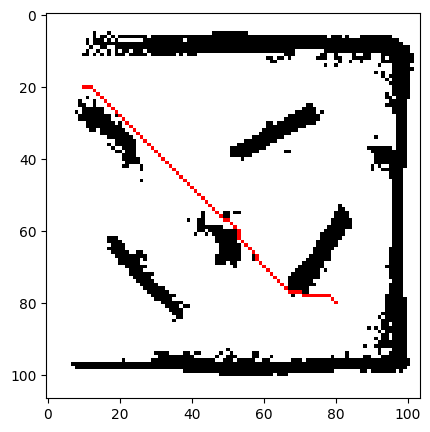

In [3]:
class Graph():
    def __init__(self, picture, alg):
        self.w, self.h= picture.shape[1], picture.shape[0]
        self.nodes = np.array([[Node(x, y) if not self.Is_Obstacle(picture, x, y) else None for x in range(self.w)]
                               for y in range(self.h)]) #массив узлов графа
        self.Create_Graph(alg)
        
    # функция создания графа со связями
    def Create_Graph(self, alg):
        move_8 = np.array([(1,0), (1,1), (0,1), (-1,1), (-1,0), (-1,-1), (0,-1), (1,-1)]) #возможные движения робота
        move_8_ex = np.array([(2,1), (1,2), (-1,2), (-2,1), (-2,-1), (-1,-2), (1,-2), (2,-1)]) #доп движения робота
        for i in range(self.w):
            for j in range(self.h):
                if self.nodes[j,i] != None:
                    n1 = self.nodes[j,i]
                    if alg in ('A*', 'Deijkstra'):
                        for x, y in move_8 + np.array([i,j]):
                            if x < 0 or y < 0 or x >= self.w or y >= self.h:
                                continue
                            if self.nodes[y,x] != None:
                                n2 = self.nodes[y,x]
                                n1.Add_neighboor(n2)
                                
                    if alg == 'RRT':
                        for x, y in move_8 + np.array([i,j]):
                            if x < 0 or y < 0 or x >= self.w or y >= self.h:
                                continue
                            if self.nodes[y,x] != None:
                                pass
    
    #Функция проверки препятствий в точке
    def Is_Obstacle(self, picture, i, j):
        px = picture[j, i]
        br = sum(px)//255//3
        return br == 0
    
    #Функция выбора лучшего узла
    def choose_best_node(self, lst, dist, alg, goal = None):
        best = None
        min_d = sys.float_info.max
        if alg == 'A*':
            for n in lst:
                d = dist[n] + np.sqrt((n.x - goal.x)**2 + (n.y - goal.y)**2)
                if d < min_d:
                    min_d = d
                    best = n
                    
            return best
                        
        elif alg == 'Deijkstra':
            for n in lst:
                d = dist[n]
                if d < min_d:
                    min_d = d
                    best = n
            
            return best
        
        elif alg == 'RRT':
            pass
    
    def FindPath(self, start, goal, alg):
        reachables = [start] #список доступных узлов
        visited = {} # словарь посещенных узлов
        dist = {} #словарь расстояний от стартовой вершины до узла
        prev = {} #словарь для запоминания пути от одного узла к другому,
        #где ключ - адрес текущего узла, значение - адрес предыдущего узла
        dist[start] = 0
        
        for i in range(self.w):
            for j in range(self.h):
                if self.nodes[j,i] != None:
                    n = self.nodes[j,i]
                    visited[n] = False
                    dist[n] = sys.float_info.max
                    if (n == start):
                        dist[n] = 0
                    
        while len(reachables) != 0:
            curr = self.choose_best_node(reachables, dist, alg, goal)
            visited[curr] = True
            reachables.remove(curr)
            
            for nxt in curr.neighboors.keys():
                if visited[nxt]:
                    continue
                    
                if nxt not in reachables:
                    reachables.append(nxt)
                
                # обновление расстояний от стартового узла до текущего
                dst = dist[curr] + curr.neighboors[nxt]
                if dst < dist[nxt]:
                    dist[nxt] = dst
                    prev[nxt] = curr
            
            
        Res = [] #список для вывода пути от старта до цели
        
        # Если целевой вершины нету, возвращаем, что такого пути нет
        if goal not in prev.keys():
            return None
        
        curr = prev[goal]
        Res.append(goal)
        while True:
            if curr == start:
                break
            Res.append(curr)
            
            if goal not in prev.keys():
                return None
            curr = prev[curr]
            
        Res.append(start)
        Res.reverse()
        return Res
    
alg = 'Deijkstra'        
img = Image.open('test1.png')
arr = np.array(img)
graph = Graph(arr, alg)
#graph.AddObstacles(arr)
putp = graph.FindPath(graph.nodes[20,10], graph.nodes[80,80], alg)
for i in range(len(putp)):
    n = putp[i]
    arr[n.y, n.x] = [255, 0, 0, 255]
    
im = Image.fromarray(arr)
im.save('result.png')
plt.figure(figsize=(5,5))
plt.imshow(im)

# Прочее

In [18]:
from tkinter import *
from tkinter.ttk import *

import matplotlib
matplotlib.use("TkAgg")
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from PIL import ImageTk, Image, ImageDraw
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

figure = Figure(figsize=(5,5), dpi=100)
plot = figure.add_subplot(1,1,1)
axprev = fig.add_axes([0.7, 0.05, 0.1, 0.075])
axnext = fig.add_axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)


def load_image():
    image = Image.open('test1.png')
    arr = np.array(image)
    plt.imshow(arr)
    


#def dijkstra():


#def a():


def clear_canvas():
    canvas.itemconfig(image_item, image='')


def maze_img():
    a = Image.open('maze.png')
    b = Image.open('random_image.png')
    maze = a + b
    maze.show()
    image = ImageTk.PhotoImage(maze)
    canvas.itemconfig(image_item, image=image)
    maze.show()

window = Tk()
canvas = FigureCanvasTkAgg(figure, window)
canvas.get_tk_widget().grid(row=0, column=0)


load_button = Button(window, text='Load Image', command=load_image)
clear_button = Button(window, text='Clear', command=clear_canvas)
maze_button = Button(window, text='add maze', command=maze_img)
dijkstra_button = Button(window, text='Дейкстра')#, command=dijkstra)
a_button = Button(window, text='A*')#, command=a)

# создание холста для вывода картинки
#canvas = Canvas(window, width=301, height=301)
#image_item = canvas.create_image(0, 0, anchor=NW)

# размещение элементов на окне
load_button.grid(row=0, column=1)
maze_button.grid(row=1, column=1)
dijkstra_button.grid(row=2, column=1)
a_button.grid(row=3, column=1)
clear_button.grid(row=4, column=1)
#canvas.grid(row=1, column=0, columnspan=5)

# запуск главного цикла программы
window.mainloop()

NameError: name 'fig' is not defined

# В разработке

In [2]:
from tkinter import *
from tkinter.ttk import *

import matplotlib
matplotlib.use("TkAgg")
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

alg = 'Deijkstra'        
img = Image.open('test1.png')
arr = np.array(img)
graph = Graph(arr, alg)
putp = graph.FindPath(graph.nodes[20,10], graph.nodes[80,80], alg)
for i in range(len(putp)):
    n = putp[i]
    arr[n.y, n.x] = [255, 0, 0, 255]
    
im = Image.fromarray(arr)
im.save('result.png')
plt.figure(figsize=(5,5))
plt.imshow(im)


ax1 = fig.add_axes([0.7, 0.05, 0.1, 0.075])
ax2 = fig.add_axes([0.81, 0.05, 0.1, 0.075])
ax3 = fig.add_axes([0.9, 0.05, 0.1, 0.075])
#axnext = fig.add_axes([0.6, 0.05, 0.1, 0.075])
b1 = Button(ax1, 'Дейкстра')
b1.on_clicked(graph.FindPath(graph.nodes[20,10], graph.nodes[80,80], 'Deijkstra'))
b2 = Button(ax2, 'A*')
b2.on_clicked(graph.FindPath(graph.nodes[20,10], graph.nodes[80,80], 'A*'))
b2 = Button(ax2, 'Reset')
b2.on_clicked()

plt.show()